# How to find time-optimal controls
**Optimizing over the duration of your controls**

Boulder Opal provides a highly-flexible optimization engine for general-purpose gradient-based optimization,
which can be directly applied to model-based control optimization in arbitrary quantum systems.
By expressing the problem as a [graph](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal) which defines the cost function to be minimized, one can obtain optimized controls which achieve the desired objectives within the constraints imposed by the system.

Boulder Opal is also capable of generating time-optimal controls by aiming to minimize the duration of the generated pulses.
This allows you to obtain not only pulses which minimize a target infidelity, but also do so in a short timescale.


## Summary workflow

### 1. Define an optimizable duration tensor

Create an optimization variable for the optimized duration
```python
optimizable_duration = graph.optimizable_scalar(
    lower_bound=0, upper_bound=max_duration, name="optimizable_duration"
)
```

### 2. Scale the values in your calculation

Set up your optimization graph similarly to [how you would otherwise](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-controls-in-arbitrary-quantum-systems-using-graphs), but multiply the energies and frequencies by the duration, and divide the times by the duration.
For example, multiply the Hamiltonian by `optimizable_duration`, and set the duration to 1.

This will lead to the same evolution, as the dynamics driven by a Hamiltonian $H$ for a time $T$ are equivalent to those driven by a (unitless) Hamiltonian $\tilde{H} = H T$ for a (unitless) time $\tilde{T} = 1$.

### 3. Define the optimization cost

As now your optimization has two targets (minimizing infidelity and duration), you need to combine them in a single node. One way of doing this is with a weighted sum of both items, for instance,

```python
cost = infidelity + 0.1 * optimizable_duration / max_duration
cost.name = "cost"
```

You can alter the incentives of the optimizer to minimize the duration or the infidelity by changing the weight of each term in the sum (or using a different form for the cost function).

### 4. Execute graph-based optimization

You can now run the optimization as usual using, for instance `boulderopal.run_optimization`.
Note that some of the output graph values might need to be rescaled back by a factor of `optimizable_duration` (or its inverse).

## Example: Optimal control of a single qubit

This example shows how to optimize a Hamiltonian with multiple controls.
Specifically, consider a single-qubit system represented by the following Hamiltonian:
$$
H(t) = \frac{1 + \beta(t)}{2} \left[\gamma(t)\sigma_{-} + \gamma^*(t)\sigma_{+}\right] + \frac{\alpha(t)}{2} \sigma_{z} \, , 
$$
where $\gamma(t)$ and $\alpha(t)$ are, respectively, complex and real time-dependent pulses, $\sigma_{\pm}$ are the qubit ladder operators, and $\sigma_{z}$ is the Pauli-Z operator.
$\beta(t)$ is a small, slowly-varying amplitude noise acting on $\gamma(t)$.

We will obtain optimal pulses for $\gamma(t)$ and $\alpha(t)$, robust to the amplitude noise $\beta(t)$, to achieve a target Y-gate operation.
Moreover, we will aim to obtain a pulse that is as short as possible by adding a penalty to the cost function that increases with the pulse duration.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

Your task (action_id="1829418") has started.
Your task (action_id="1829418") has completed.
Optimized cost:		4.475e-02
Optimized infidelity:	6.819e-05
Optimized duration:	4.468e-06


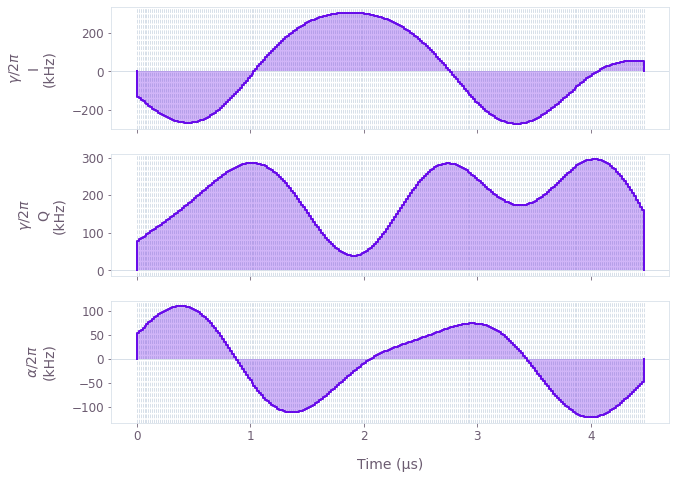

In [2]:
# Define physical constants.
gamma_max = 2 * np.pi * 3e5  # rad/s
alpha_max = 2 * np.pi * 1e5  # rad/s
cutoff_frequency = 5e6  # Hz
segment_count = 16
max_duration = 10e-6  # s

# Create the graph describing the system.
graph = bo.Graph()

# Define optimizable duration.
duration = graph.optimizable_scalar(0, max_duration)
duration.name = "duration"

# Create a optimizable complex-valued piecewise-constant (PWC) signal.
rough_gamma = graph.complex_optimizable_pwc_signal(
    segment_count=segment_count, maximum=gamma_max, duration=1.0
)
# Smooth the signal.
gamma = graph.filter_and_resample_pwc(
    pwc=rough_gamma,
    segment_count=256,
    kernel=graph.sinc_convolution_kernel(cutoff_frequency * duration),
    name=r"$\gamma$",
)

# Create a PWC operator representing the drive term.
drive = graph.hermitian_part(gamma * graph.pauli_matrix("M"))

# Create an optimizable real-valued PWC signal.
rough_alpha = graph.real_optimizable_pwc_signal(
    segment_count=segment_count, minimum=-alpha_max, maximum=alpha_max, duration=1.0
)
# Smooth the signal.
alpha = graph.filter_and_resample_pwc(
    pwc=rough_alpha,
    segment_count=256,
    kernel=graph.sinc_convolution_kernel(cutoff_frequency * duration),
    name=r"$\alpha$",
)
# Create a PWC operator representing the clock shift term.
shift = alpha * graph.pauli_matrix("Z") / 2

# Define the total Hamiltonian.
hamiltonian = drive + shift

# Create the infidelity.
infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian * duration,
    target=graph.target(graph.pauli_matrix("Y")),
    noise_operators=[drive * duration],
    name="infidelity",
)

cost = infidelity + 0.1 * duration / max_duration
cost.name = "cost"

# Run the optimization.
result = bo.run_optimization(
    graph=graph,
    cost_node_name="cost",
    output_node_names=[r"$\alpha$", r"$\gamma$", "duration", "infidelity"],
    optimization_count=20,
)
print(f"Optimized cost:\t\t{result['cost']:.3e}")
print(f"Optimized infidelity:\t{result['output']['infidelity']['value']:.3e}")
optimized_duration = result["output"]["duration"]["value"]
print(f"Optimized duration:\t{optimized_duration:.3e}")

# Plot the optimized controls, scaling back the durations.
gamma_durations = result["output"][r"$\gamma$"]["durations"] * optimized_duration
gamma_values = result["output"][r"$\gamma$"]["values"]

alpha_durations = result["output"][r"$\alpha$"]["durations"] * optimized_duration
alpha_values = result["output"][r"$\alpha$"]["values"]

qv.plot_controls(
    {
        r"$\gamma$": {"durations": gamma_durations, "values": gamma_values},
        r"$\alpha$": {"durations": alpha_durations, "values": alpha_values},
    },
    polar=False,
)
plt.show()